Sample size = 40,000 points
Monte Carlo estimation for probability = 0.135208
Actual probability = 0.135335
Percent relative error = -0.094420%


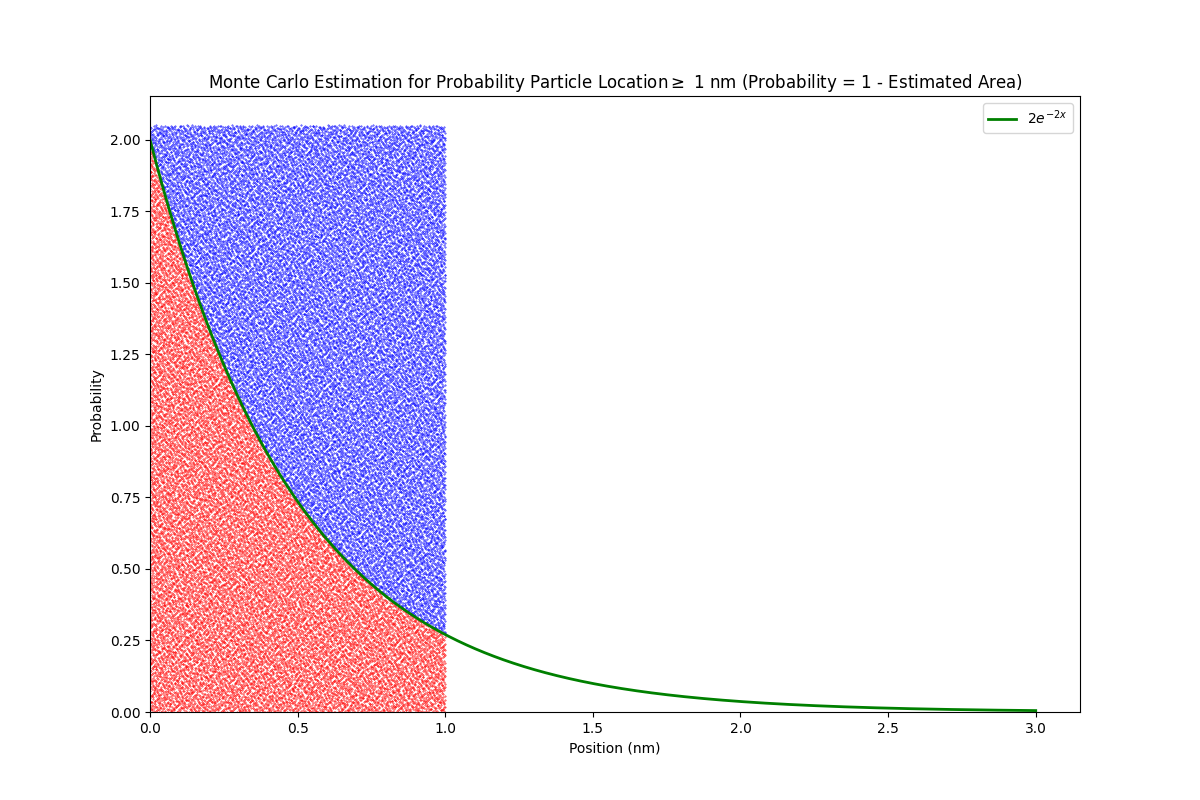

In [25]:
"""particle_location.ipynb"""
# Cell 1: Estimate the probability the particle described by a given wave function will be found in 
# the region x >= 1 nm using Monte Carlo estimation.

# Imports
from __future__ import annotations

import typing

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import MarkerStyle
from matplotlib.patches import Rectangle
from numba import float64, vectorize  # type: ignore
import scipy.integrate  # type: ignore
from IPython.core.display import Math

if typing.TYPE_CHECKING:
    from matplotlib.axes import Axes
    from numpy.typing import NDArray

%matplotlib widget


def pdf(x: NDArray[np.float_]) -> NDArray[np.float_]:
    """Probability Density Function (PDF) for the particle location described 
    by the given wave function and L == 1 nm"""
    return 2 * np.exp(-2 * x)

def cdf(x: float) -> float:
    """Cumulative Density Function (CDF) for the particle location described
    by the given wave function and L == 1 nm"""
    return -np.exp(-2 * x) + 1


@vectorize([float64(float64, float64)], nopython=True)  # type: ignore
def halton(n: float, p: int) -> float:
    """Halton Quasi-Random Number Generator, returns a random float in the interval 
    [0, 1]"""
    h = 0
    f = 1
    while n > 0:
        f: float = f / p
        h += (n % p) * f
        n = int(n / p)
    return h


def plot_location_probability(ax: Axes) -> None:
    """Use Monte Carlo estimation to find the probability a particle will be found 
    in the region x >= 1 nm"""

    points: int = 40_000 # Number of dots for the Monte Carlo estimation

    # Define sample area for the Monte Carlo estimation
    sample_area = Rectangle((0, 0), 1, 2.05)

    # List of primes for the Halton QRNG
    primes: list[int] = [2, 3]

    # Array for random x values
    x: NDArray[np.float_] = (
        sample_area.get_x() 
        + halton(np.arange(points), primes[0]) * sample_area.get_width() # type: ignore
    )

    # Array to store random y values
    y: NDArray[np.float_] = (
        sample_area.get_y()
        + halton(np.arange(points), primes[1]) * sample_area.get_height() # type: ignore
    )

    # Array to store vertical distances between each random point and actual PDF graph
    d: NDArray[np.float_] = pdf(x) - y

    # Arrays to store the random x and y values below (or on) the PDF curve
    x_in: NDArray[np.float_] = x[d >= 0]
    y_in: NDArray[np.float_] = y[d >= 0]

    # Arrays to store the random x and y values above the PDF curve
    x_out: NDArray[np.float_] = x[d < 0]
    y_out: NDArray[np.float_] = y[d < 0]

    # Format scatter plot marker to be the size of one pixel for given screen
    pixel_size: float = (72 / ax.figure.dpi) ** 2  # type: ignore
    # Create scatter plot of points both inside and outside the PDF curve
    ax.scatter(x_in, y_in, color="red", marker=MarkerStyle("."), s=pixel_size)
    ax.scatter(x_out, y_out, color="blue", marker=MarkerStyle("."), s=pixel_size)

    # Plot the actual PDF
    pdf_x: NDArray[np.float_] = np.linspace(0, 3, 1000)
    pdf_y: NDArray[np.float_] = pdf(pdf_x)
    ax.plot(pdf_x, pdf_y, color="green", linewidth=2, label="$2e^{-2x}$")

    # Find estimated area under the curve
    est_integral: float = (
        (np.count_nonzero(d >= 0) / points)
        * (sample_area.get_width() * sample_area.get_height())
    )

    # Subtract area under curve from 1 to get probability the particle's position
    # is >= 1 nm
    mc_probability: float = 1 - est_integral

    # Find actual area under the curve between 0 and 1 nm using the CDF
    act_integral: float = cdf(
        sample_area.get_x() + sample_area.get_width()) - cdf(sample_area.get_x()
    )

    # Subtract area under curve found using CDF from 1 to get probability the 
    # particle's position is >= 1 nm
    cdf_probability: float = 1 - act_integral

    # Calculate relative error between the Monte Carlo estimation and the CDF
    rel_error: float = (mc_probability - cdf_probability) / cdf_probability

    # Display the sample size, Monte Carlo probability estimation, actual 
    # probability, and % relative error
    print(f"Sample size = {points:,} points")
    print(f"Monte Carlo estimation for probability = {mc_probability:.6f}")
    print(f"Actual probability = {cdf_probability:.6f}")
    print(f"Percent relative error = {rel_error:.6%}")

    # Set titles, labels, and legend
    ax.set_title(
        rf"Monte Carlo Estimation for Probability Particle Location"
        rf"$\geq$ 1 nm (Probability = 1 - Estimated Area)"
    )
    ax.set_xlabel(f"Position (nm)")
    ax.set_ylabel("Probability")
    ax.legend(loc="upper right")

    ax.set_xlim(0)
    ax.set_ylim(0)
    

def main() -> None:
    plt.close("all")
    plt.figure(" ", figsize=(12, 8))
    plot_location_probability(plt.axes())
    plt.show()

main()

In [22]:
# Cell 2: Find the probability calculated above using Scipy Integrate.

actual_probability: float = scipy.integrate.quad(pdf, 1, np.inf)[0]  # type: ignore
print("Probability particle will be found in the following region:")
display(Math(rf"x\geq1\;nm:\;{actual_probability:.6f}"))

Probability particle will be found in the following region:


<IPython.core.display.Math object>